In [3]:
# Regex
import re
# Data Ops
import pandas as pd
import numpy as np
# Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

### General Information and assumptions

### Data Sources

For my project I included three datasets:
1. The Top 250 from Beer Advocate dataset for gathering beer general styles available at Kaggle: https://www.kaggle.com/datasets/bengosha/beer-advocate-top-250-beers
2. Untappd Beer Data dataset to get information for ABV, IBU and beer style available at Kaggle: https://www.kaggle.com/datasets/jailenbailey/untappd-beer-data
3. The Open Beer Database to get additional rows for ABV, IBU and beer style available at: https://openbeerdb.com/

So we can have a little more room to make analysis, we will use the "untappd" and "open beer" datasets since both include the IBU, and not only the abv.

After some initial trials fitting the datasets using linear regression, $R^2$ was too low to make any predictions. We then will try to use Random Forests, Adaboost Classifier and KNN to predict the style of been from the combination of ABV and IBU.

ABV and IBU context:

https://fr.wikipedia.org/wiki/International_Bitterness_Unit

https://en.wikipedia.org/wiki/Alcohol_by_volume

Here are some samples from each dataset below:

In [4]:
data_sources = {
    'beer_advocate': './data/beeradvocate_top250.csv',
    'untappd':'./data/my_beer.csv',
    'open_beer':'./data/open_beer.csv'
}

df_beer_advocate, df_untappd, df_open_beer = (pd.read_csv(data_sources[f]) for f in data_sources)
df_untappd = df_untappd.rename(columns={'beer_type':'beer_style','global_rating_score':'review_overall'})

In [5]:
df_beer_advocate.sample(5)

,rank,beer_name,brewery,style,alcohol_pct,n_ratings,avg_rating,general_style,substyle
141,142,Speedway Stout - Bourbon Barrel-Aged,AleSmith Brewing Company,Stout - American Imperial,12.0,2310,4.52,Stout,American Imperial
147,148,Affogato - Bourbon Barrel-Aged,Trillium Brewing Company,Stout - American Imperial,14.9,169,4.55,Stout,American Imperial
208,209,Consecration,Russian River Brewing Company,Wild Ale,10.0,5592,4.49,Wild Ale,NaN
85,86,Triple Shot,Tree House Brewing Company,Stout - American Imperial,9.7,647,4.57,Stout,American Imperial
227,228,PNC Imperial Buckwheat Stout,Firestone Walker Brewing Co.,Stout - American Imperial,13.7,520,4.49,Stout,American Imperial


In [6]:
df_untappd.iloc[:,:5].sample(5)

,beer_name,brewery_name,beer_style,beer_abv,beer_ibu
96,Watermelon Sour,Wicked Weed Brewing,Sour - Other,0.0,0
147,S3 Raspberry Sour,Kilowatt Brewing,Sour - Berliner Weisse,3.3,0
186,Divine Light w/ Strawberry,BattleMage Brewing,Fruit Beer,4.8,0
0,Delirium Tremens,Delirium - Huyghe Brewery,Belgian Strong Golden Ale,8.5,24
113,Colorvision,Fatty's Beer Works,Sour - Fruited,0.0,0


In [7]:
df_open_beer.sample(5)

,index,beer_name,beer_abv,beer_ibu,beer_style
1148,1148,Promethean Porter,0.0,0.0,Porter
220,220,Old Krogh Oatmeal Stout,0.0,0.0,American-Style Stout
1933,1933,Amber Ale,0.0,0.0,American-Style Amber/Red Ale
548,548,Raging Bitch Belgian IPA,8.3,0.0,Other Belgian-Style Ales
1788,1788,Beer Geek Breakfast,7.5,0.0,American-Style Imperial Stout


In [13]:
print(df_open_beer.beer_style.nunique())
print(df_untappd.beer_style.nunique())

68
79


### Data Exploration

##### Beer Styles

As we can see from samples, there are too many beer styles to work with, so with the purpose of simplyfing, I will generalize the beer styles that are known to me and are most popular in my opinion. In further attempts doing the same analysis it will be more interesting and precise to include all detailed styles, buy in my opinion we would need a larger dataset. Apart from ABV and IBU an interesting feature to include could be EBC and price. This could probably increase the precission in large meassure (especially EBC).

Using the Beer Advocate dataset we will get an idea of the different general and detailed styles, and then select and filter from there.

In [6]:
all_gen_styles = df_beer_advocate[['general_style']].groupby('general_style').nunique().index.values
gen_styles =['IPA','Lambic','Pale Ale','Porter','Sour','Stout']
all_styles_reviews = list(df_untappd[['beer_style']].groupby('beer_style').nunique().index.values)
gen_styles += ['Ale','Altbier','Pilsner','Belgian','Bock','Weissbier','Dubbel','Bitter','Lager','Weizen','Kölsch']
gen_styles = [n.lower() for n in gen_styles]
gen_styles

['ipa',
 'lambic',
 'pale ale',
 'porter',
 'sour',
 'stout',
 'ale',
 'altbier',
 'pilsner',
 'belgian',
 'bock',
 'weissbier',
 'dubbel',
 'bitter',
 'lager',
 'weizen',
 'kölsch']

### Data Cleaning

* Let's replace the "beer_styles" values with a more general style and drop any rows that are not in the general style array I'm using regex to find similarities in the style name pattern.
* Drop the different review details and keep the overall review only.

In [7]:
class Beer_Data:
    def __init__(self, gen_styles, df_untappd, df_open_beer) -> None:
        self.styles = [s for s in gen_styles]
        df_untappd = self.remove_outliers(df_untappd)
        df_untappd = self.clean_data_untappd(df_untappd)
        df_untappd.dropna()
        df_open_beer = self.remove_outliers(df_open_beer)
        df_open_beer = self.clean_data_open_beer(df_open_beer)
        df_open_beer.dropna()
        frames = [df_untappd,df_open_beer]
        self.df = pd.concat(frames)
        self.columns = list(self.df.columns.values)
        self.data_X = self.df[['beer_abv','beer_ibu']]
        self.data_y = self.df['beer_style']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data_X,
            self.data_y,
            test_size=0.2
        )

    def remove_outliers(self, df: pd.DataFrame)-> pd.DataFrame:
        outlier_styles = ['imperial','strong']
        general_style_regex = [re.compile(r'(?i)[ A-z0-9 ]*.*'+s+r'[ A-z0-9 ]*.*') for s in outlier_styles]
        i = df["beer_style"].str.contains(general_style_regex[0],regex=True) == True
        s = df["beer_style"].str.contains(general_style_regex[1],regex=True) == True
        a = df['beer_abv'] > 20
        i = df['beer_ibu'] < 1
        return df[~(i + s + a + i)]

    def clean_data_untappd(self, df: pd.DataFrame)-> pd.DataFrame:
        general_style_regex = {re.compile(r'(?i)[ A-z0-9 ]*.*'+s+r'[ A-z0-9 ]*.*'): s.capitalize() for s in self.styles}
        df.beer_style = df.beer_style.replace(
            general_style_regex,
            regex=True
        )
        df = df.drop(columns=[
            'brewery_id','bid','comment','venue_name','venue_country','venue_city', 'venue_state','venue_lat',
            'venue_lng','rating_score','created_at','checkin_url','beer_url','brewery_url','brewery_country',
            'brewery_city','brewery_state','flavor_profiles','purchase_venue','serving_type','checkin_id',
            'brewery_id','photo_url','global_weighted_rating_score','tagged_friends','total_toasts','total_comments'
        ]).assign(
            review_overall = df.review_overall,
            beer_abv = df.beer_abv,
            beer_ibu = df.beer_ibu,
            brewery_name = df.brewery_name.astype('category'),
            beer_name = df.beer_name.astype('category')
        )
        df = df.loc[df['beer_style'].isin(
            [s.capitalize() for s in gen_styles]
        )].dropna()
        return df

    def clean_data_open_beer(self, df: pd.DataFrame)-> pd.DataFrame:
        general_style_regex = {re.compile(r'(?i)[ A-z0-9 ]*.*'+s+r'[ A-z0-9 ]*.*'): s.capitalize() for s in self.styles}
        df.beer_style = df.beer_style.replace(
            general_style_regex,
            regex=True
        )
        df = df.drop(columns=[
            'index',
        ]).assign(
            beer_abv = df.beer_abv,
            beer_ibu = df.beer_ibu,
            beer_name = df.beer_name.astype('category'),
            beer_style = df.beer_style.astype('category')
        )
        df = df.loc[df['beer_style'].isin(
            [s.capitalize() for s in gen_styles]
        )].dropna()
        return df


In [8]:
beer_data = Beer_Data(gen_styles, df_untappd, df_open_beer)

Exploratory Data Analysis

<AxesSubplot: >

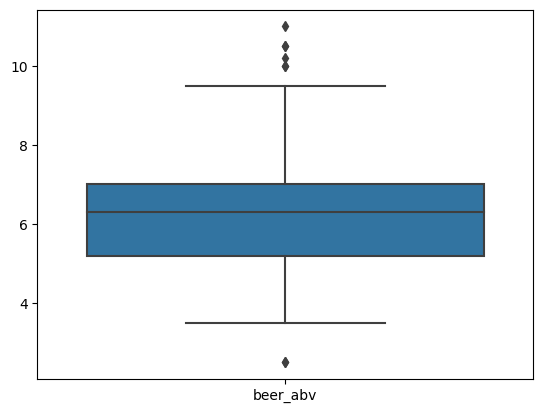

In [9]:
sns.boxplot(pd.DataFrame(beer_data.df.beer_abv))

<AxesSubplot: >

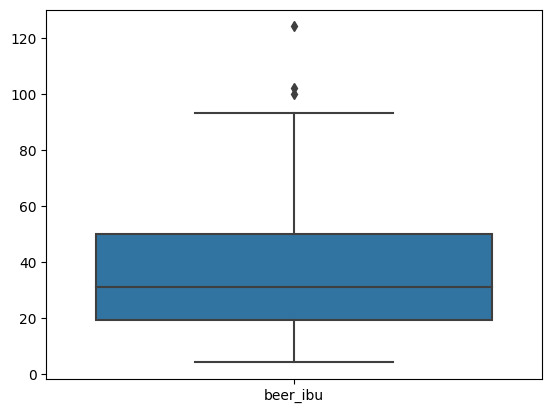

In [10]:
sns.boxplot(pd.DataFrame(beer_data.df.beer_ibu))

<AxesSubplot: xlabel='beer_abv', ylabel='Count'>

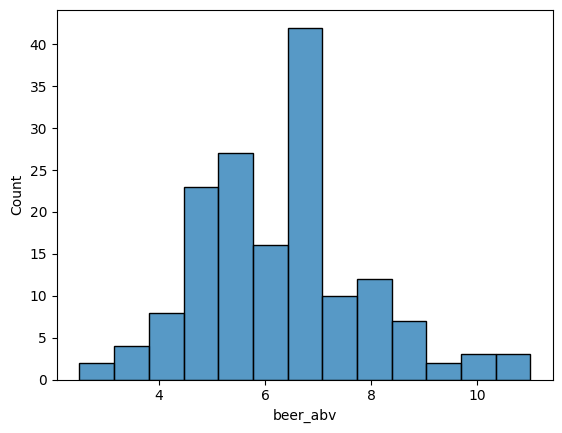

In [11]:
sns.histplot(beer_data.df.beer_abv)

<AxesSubplot: xlabel='beer_ibu', ylabel='Count'>

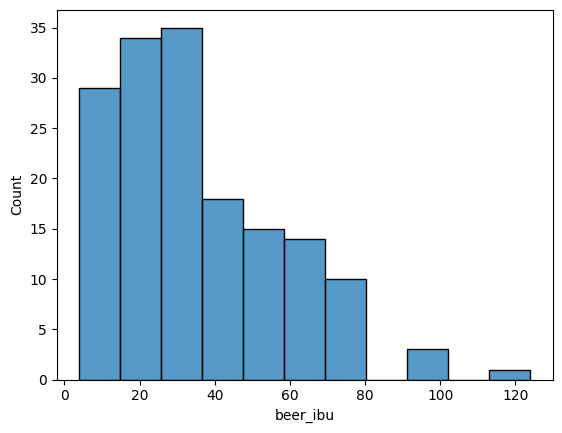

In [12]:
sns.histplot(beer_data.df.beer_ibu)

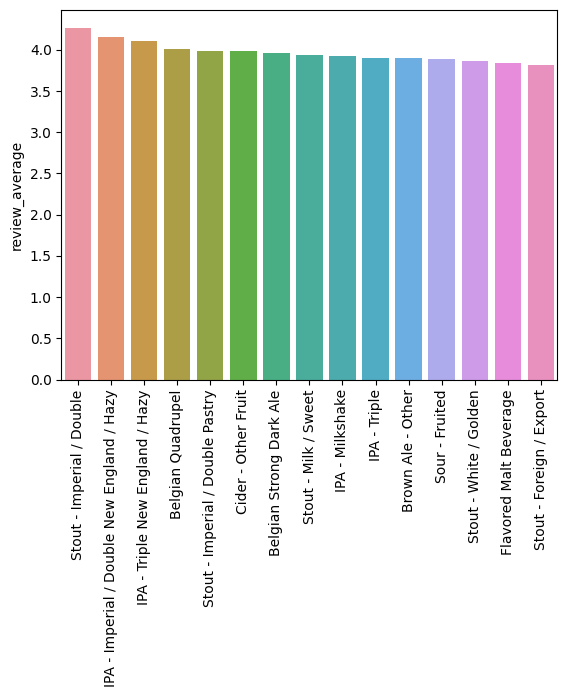

In [13]:
review_by_style =  df_untappd[
    ['review_overall','beer_style']
].groupby(
    'beer_style'
).aggregate(
    review_average=('review_overall','mean'),
    review_min=('review_overall','min'),
    review_max=('review_overall','max'),
    review_median=('review_overall','median')
).sort_values(
    by='review_average',ascending=False
).iloc[:15,:]
style_barplot = sns.barplot(review_by_style,x=review_by_style.index.values,y='review_average')
plt.xticks(rotation=90)
plt.show()

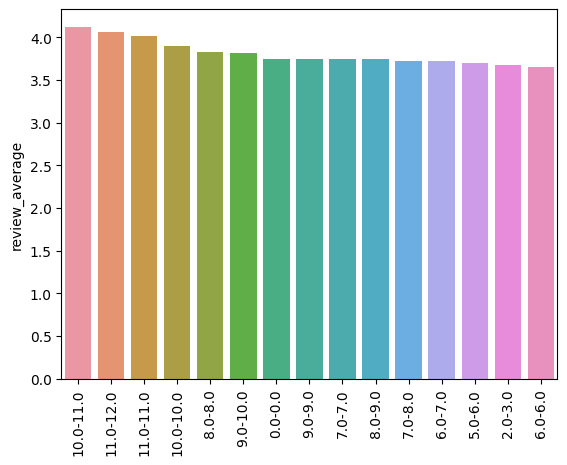

In [14]:
review_by_abv =  df_untappd[
    ['review_overall','beer_abv']
].assign(
    abv_floor = np.floor(df_untappd['beer_abv']),
    abv_ceil = np.ceil(df_untappd['beer_abv'])
)
review_by_abv["abv_range"] = review_by_abv["abv_floor"].astype(str) + '-' +review_by_abv["abv_ceil"].astype(str)
review_by_abv = review_by_abv.drop(columns=['abv_floor','abv_ceil','beer_abv'])
review_by_abv = review_by_abv.groupby(
    'abv_range'
).aggregate(
    review_average=('review_overall','mean'),
).sort_values(
    by='review_average',ascending=False
).iloc[:15,:]
abv_barplot = sns.barplot(review_by_abv,x=review_by_abv.index.values,y='review_average')
plt.xticks(rotation=90)
plt.show()

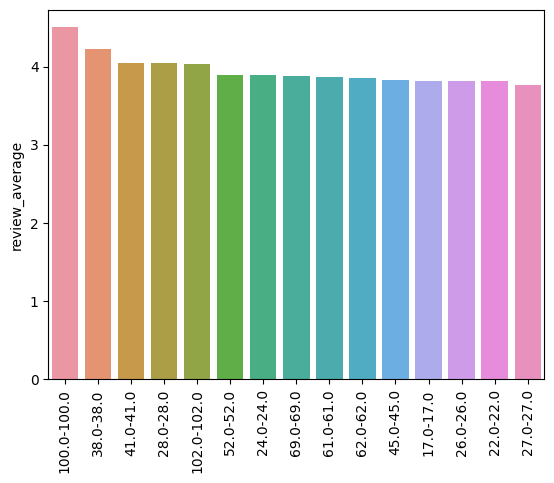

In [15]:
review_by_ibu =  df_untappd[
    ['review_overall','beer_ibu']
].assign(
    ibu_floor = np.floor(df_untappd['beer_ibu']),
    ibu_ceil = np.ceil(df_untappd['beer_ibu'])
)
review_by_ibu["ibu_range"] = review_by_ibu["ibu_floor"].astype(str) + '-' +review_by_ibu["ibu_ceil"].astype(str)
review_by_ibu = review_by_ibu.drop(columns=['ibu_floor','ibu_ceil','beer_ibu'])
review_by_ibu = review_by_ibu.groupby(
    'ibu_range'
).aggregate(
    review_average=('review_overall','mean'),
).sort_values(
    by='review_average',ascending=False
).iloc[:15,:]
abv_barplot = sns.barplot(review_by_ibu,x=review_by_ibu.index.values,y='review_average')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot: xlabel='beer_ibu', ylabel='review_overall'>

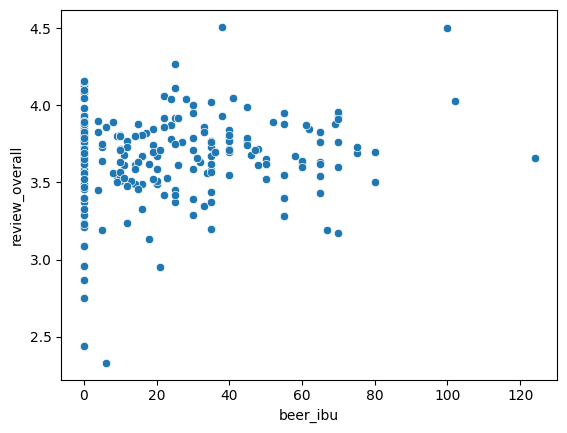

In [16]:
sns.scatterplot(df_untappd, x='beer_ibu',y='review_overall')

<AxesSubplot: xlabel='beer_abv', ylabel='review_overall'>

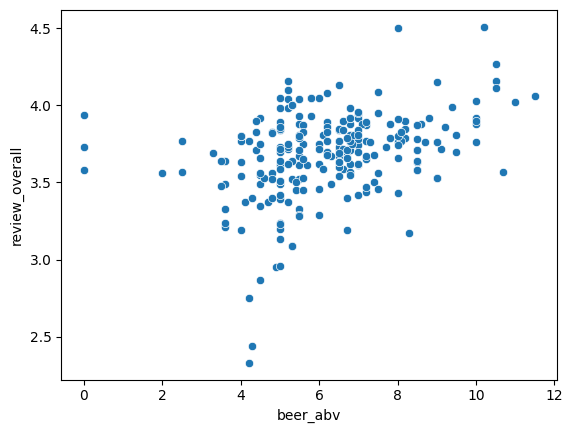

In [17]:
sns.scatterplot(df_untappd, x='beer_abv',y='review_overall')

In [59]:
class Beer:
    def __init__(self, beer_data: Beer_Data) -> None:
        self.random_forest = RandomForestClassifier(
            max_depth=2, 
            random_state=1984
        ).fit(
            beer_data.X_train, 
            beer_data.y_train
        )
        self.random_forest_predictions = self.random_forest.predict(beer_data.X_test) 
        self.random_forest_score = self.random_forest.score(beer_data.X_test,beer_data.y_test)
        self.adaboost_classifier = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), 
            n_estimators=200
        ).fit(
            beer_data.X_train, 
            beer_data.y_train
        
        )
        self.knn = KNeighborsClassifier(n_neighbors=5).fit(beer_data.X_train, beer_data.y_train)

        self.adaboost_classifier_predictions = self.adaboost_classifier.predict(beer_data.X_test)
        self.adaboost_classifier_score = self.adaboost_classifier.score(beer_data.X_test,beer_data.y_test)
        self.knn_score = self.knn.score(beer_data.X_test,beer_data.y_test)
    
    def predict_model_random_forest(self, df: pd.DataFrame)-> pd.DataFrame:
        return [str(p) for p in self.adaboost_classifier.predict(df)]

    def predict_model_adaboost(self, df: pd.DataFrame)-> pd.DataFrame:
        return [str(p) for p in self.random_forest.predict(df)]

    def predict_knn(self, df: pd.DataFrame)-> pd.DataFrame:
        return [str(p) for p in self.knn.predict(df)]

In [60]:
beer = Beer(beer_data)

In [61]:
my_test = pd.DataFrame(data={
    'name':['Lagunitas','Guinness','Duvel','Franziskaner', 'Corona', 'Sierra Nevada Torpedo', 'Orval', 'Fullers London Pride', 'Heineken', 'Meantime London Porter'],
    'beer_abv':[6.2, 4.2, 8.5, 5, 4.5, 7.2, 6.2, 4.7, 5, 6.5],
    'beer_ibu':[51, 45, 33, 10, 18, 65, 36, 22, 19, 35]
})
my_test

,name,beer_abv,beer_ibu
0,Lagunitas,6.2,51
1,Guinness,4.2,45
2,Duvel,8.5,33
3,Franziskaner,5.0,10
4,Corona,4.5,18
5,Sierra Nevada Torpedo,7.2,65
6,Orval,6.2,36
7,Fullers London Pride,4.7,22
8,Heineken,5.0,19
9,Meantime London Porter,6.5,35


In [62]:
rf_pred = beer.predict_model_random_forest(my_test.iloc[:,1:])
ab_pred = beer.predict_model_adaboost(my_test.iloc[:,1:])
knn_pred = beer.predict_knn(my_test.iloc[:,1:])
names = [v[0] for v in my_test.iloc[:,:1].values]
for t, rf, ab, knn in zip(names,rf_pred, ab_pred, knn_pred):
    print(f'Name: {t}, Random Forest: {rf}, AdaBoost: {ab}, KNN: {knn}')

Name: Lagunitas, Random Forest: Ipa, AdaBoost: Ipa, KNN: Ipa
Name: Guinness, Random Forest: Stout, AdaBoost: Ale, KNN: Ipa
Name: Duvel, Random Forest: Ipa, AdaBoost: Ipa, KNN: Stout
Name: Franziskaner, Random Forest: Lambic, AdaBoost: Sour, KNN: Ale
Name: Corona, Random Forest: Ale, AdaBoost: Ale, KNN: Ale
Name: Sierra Nevada Torpedo, Random Forest: Ipa, AdaBoost: Ipa, KNN: Ipa
Name: Orval, Random Forest: Ipa, AdaBoost: Ipa, KNN: Ipa
Name: Fullers London Pride, Random Forest: Stout, AdaBoost: Ale, KNN: Kölsch
Name: Heineken, Random Forest: Ipa, AdaBoost: Ale, KNN: Ale
Name: Meantime London Porter, Random Forest: Ipa, AdaBoost: Ipa, KNN: Ipa
